[View in Colaboratory](https://colab.research.google.com/github/sungreong/Pymc3_bayseian/blob/master/Variational_API_quickstart.ipynb)

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [11]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/GPU")
!ls


fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
annotations	    data   filter  images	  imFunctions.py  __pycache__
annotations.tar.gz  drive  graphs  images.tar.gz  output	  torch_gan


## 원하는 .png 이미지 호스팅하기

* 이미지 호스팅 해주는 사이트에 가입한다. https://u6135.imgbb.com/
*  그다음에 원하는 사진을 올린다
* 그다음에 해당 사진의 url 을 복사한다
* 끝


ex )

![iris](https://thumb.ibb.co/hwdYfd/iris.png)

## 공식 넣기  
$
\dot{x} = \sigma(x-y) \\
{x}^2 + 3x + {x}^{3} + 2x $



In [0]:
!pip install git+https://github.com/pymc-devs/pymc3
!pip install patsy pandas
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook")
plt.style.use("seaborn-darkgrid")
print('Running on PyMC3 v{}'.format(pm.__version__))

## Variational API quickstart
* 근사화하는 사후분포에 초점을 맞추는 **api**이다
* 임의적인  방법들을 계산하고 사후분포를 샘플링한다.
*  **eval** 을 사용하여  symbolic 을 없애고 값을 실제로 볼 수 있다.


In [0]:
np.random.seed(42)
pm.set_tt_rng(42)

#  기초 단계

* 밑에 식은 우리가 계산적으로는  기댓 값을 구할 수 없다. 하지만 mcmc(Nuts) 를 이용하여 근사적으로는 가능하다.

In [0]:
w = pm.floatX([.2, .8])
mu = pm.floatX([-.3, .5])
sd = pm.floatX([.1, .1])
import theano
with pm.Model() as model :
    x = pm.NormalMixture("x", w=w , mu=mu , sd=sd, dtype= theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

*  저장된것을 샘플링하기 위해 **Deterministci** 이라는 객체로 감싸줄 필요가 있다.





In [0]:
with model :
    pm.Deterministic("x3", x2)
    pm.Deterministic("sin_x", sin_x)

In [26]:
with model:
    trace = pm.sample(50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x]
100%|██████████| 50500/50500 [00:20<00:00, 2434.60it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10514495c0>,
      dtype=object)

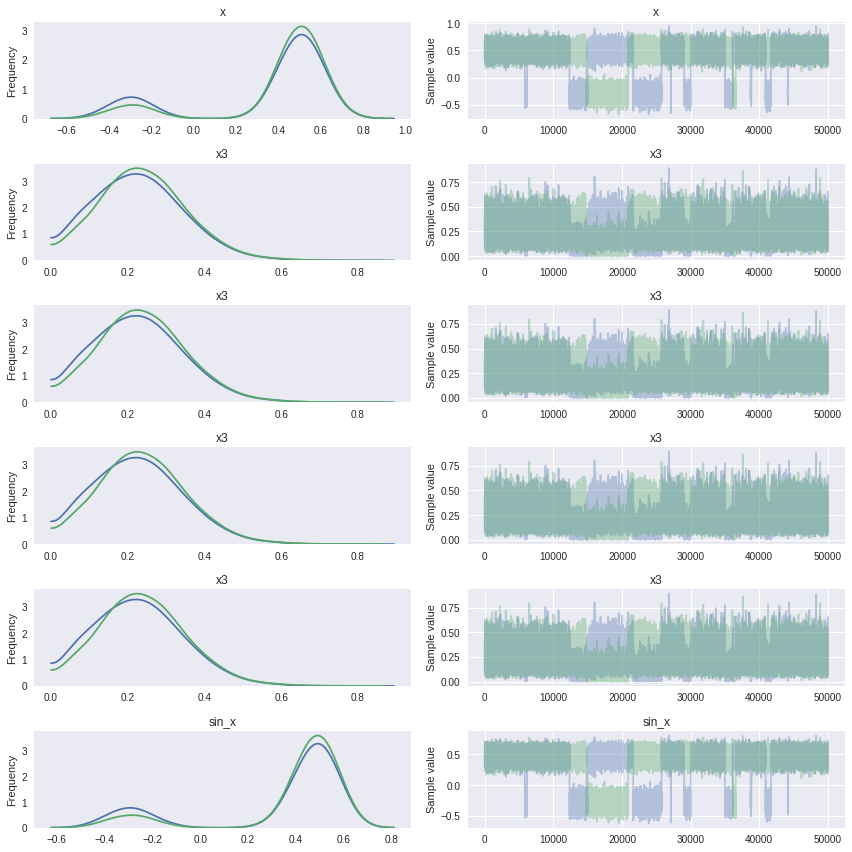

In [27]:
pm.traceplot(trace)


$ x^{2} , \  sin(x)   $  흔적을 볼 수 있다.  **multi modality** 를 확인 할 수 있다

* 한가지 단점은 너가 사전에 흔적안에서 정확히 알고 싶은 것과 Deterministic으로 감싼 것을 정확히 알 때만 가능하다.

In [0]:
with pm.Model() as model :
    x = pm.NormalMixture("x", w=w, mu=mu , sd=sd , dtype= theano.config.floatX)
    x2 = x ** 2
    sin_x = pm.math.sin(x)

In [30]:
with model :
     mean_field = pm.fit(method="advi")

Average Loss = 2.2413: 100%|██████████| 10000/10000 [00:06<00:00, 1643.80it/s]


Finished [100%]: Average Loss = 2.2687


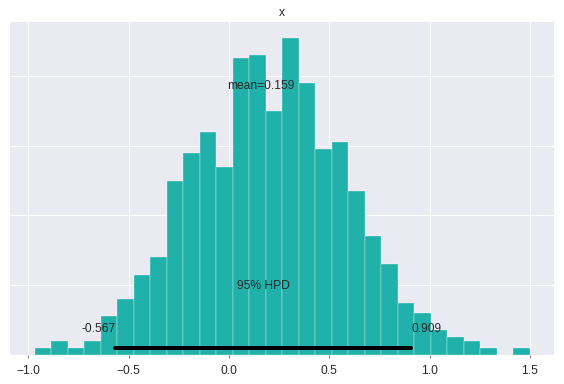

In [31]:
pm.plot_posterior(mean_field.sample(1000), color= "LightSeaGreen")

## Check
* **ADVI**는 **MULTIMODAL distribution**을  알아내는데 실패했다. 
* 왜냐하면 가우시안 분포는 모드가 한개뿐이기 때문이다.

## Checking Convergence

In [32]:
help(pm.callbacks.CheckParametersConvergence)

Help on class CheckParametersConvergence in module pymc3.variational.callbacks:

class CheckParametersConvergence(Callback)
 |  Convergence stopping check
 |  
 |  Parameters
 |  ----------
 |  every : int
 |      check frequency
 |  tolerance : float
 |      if diff norm < tolerance : break
 |  diff : str
 |      difference type one of {'absolute', 'relative'}
 |  ord : {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
 |      see more info in :func:`numpy.linalg.norm`
 |  
 |  Examples
 |  --------
 |  >>> with model:
 |  ...     approx = pm.fit(
 |  ...         n=10000, callbacks=[
 |  ...             CheckParametersConvergence(
 |  ...                 every=50, diff='absolute',
 |  ...                 tolerance=1e-4)
 |  ...         ]
 |  ...     )
 |  
 |  Method resolution order:
 |      CheckParametersConvergence
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, approx, _, i)
 |      Call self as a function.
 |  
 |  __init__(self, e

In [35]:
from pymc3.variational.callbacks import CheckParametersConvergence

with model:
    mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()])

Average Loss = 2.0774: 100%|██████████| 10000/10000 [00:05<00:00, 1767.51it/s]


Finished [100%]: Average Loss = 2.1059


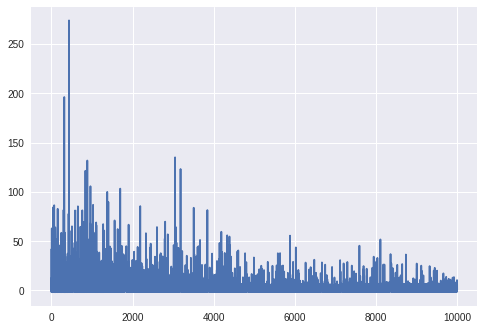

In [36]:
plt.plot(mean_field.hist);

* 많은 반복을 했는데도 ,  잘  convergence한 그림은 아닌다  
* 왜냐하면 ,  **ADVI**의 approximation의 평균이 거의 0이기 때문이다. 
* 그러므로 상대적인(relative) 차이는  수렴을 확인하는데 불안전하다

In [37]:
with model :
    mean_field = pm.fit(method="advi",callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])

Average Loss = 2.7858:  47%|████▋     | 4661/10000 [00:02<00:02, 1887.13it/s]
Convergence achieved at 4700
Interrupted at 4,699 [46%]: Average Loss = 4.8263


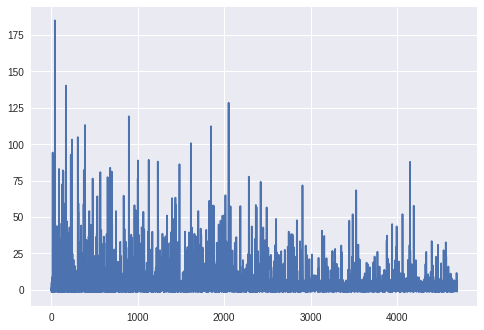

In [38]:
plt.plot(mean_field.hist);

* **relative difference** 에서 **absolute difference** 로 변경해주니 더 나은 수렴을 확인 할 수 있다.

## Tracking Parameters 
* 또다른 **call back** 은 사용자들에게 모수들을 Tracking 할수 있게 해준다.
*  추론하는 동안 임의의 통계량을 tracking 하게 해준다. 
* **FIT** 함수를 사용하여 우리는 추론 전에 직접적인 근사치를 얻을 수 있다.
* **그러나**  TRACKING PARAMETERS 은 근사치에 대한 접근이 필요하다 
* **Object-Oriented(OO)** 를 사용하여 제한 할 수 있다.

In [0]:
with model :
    advi = pm.ADVI()

In [40]:
advi.approx

* Different approximations have different hyperparameters. In mean-field ADVI, 
* we have $ρ$ and $μ$ (inspired by Bayes by BackProp).
https://arxiv.org/abs/1505.05424

In [42]:
advi.approx.shared_params

## 근사치에 관련한 편리한 단축키다   우리가 Nuts sampling 의 mass matrix 를 구체화할 때 유용하다

{'mu': mu, 'rho': rho}

In [43]:
advi.approx.mean.eval() , advi.approx.std.eval()

(array([0.34]), array([0.69314718]))

In [0]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)

In [45]:
# advi.fit 은 mean 과 std 을 기록 할 것이다 

approx = advi.fit(20000, callbacks=[tracker])

Average Loss = 2.1952: 100%|██████████| 20000/20000 [00:12<00:00, 1549.04it/s]


Finished [100%]: Average Loss = 2.1996


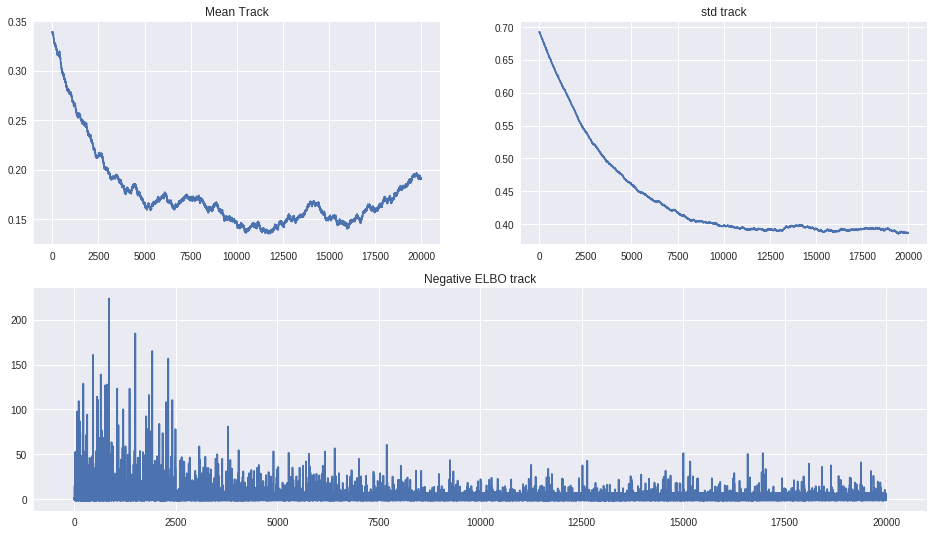

In [50]:
## ELBO (Evidence Lower Bound)  and Parametes traces

fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean Track")
std_ax.plot(tracker["std"])
std_ax.set_title("std track")
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

## mean 에 대해서는 수렴에 아직 이슈가 남아 있다.
* 수렴의 부족은 ELBO 사선에 즁요하게 영향을 끼치는 것은 아닌 것 같다.
* **OO API**를 사용하면 우리는 수렴을 달성하기 전에 더 긴 근사화를 할 수 있다.

In [51]:
advi.refine(100000)

Average Loss = 2.0546: 100%|██████████| 100000/100000 [01:26<00:00, 1150.40it/s]


Finished [100%]: Average Loss = 2.0485


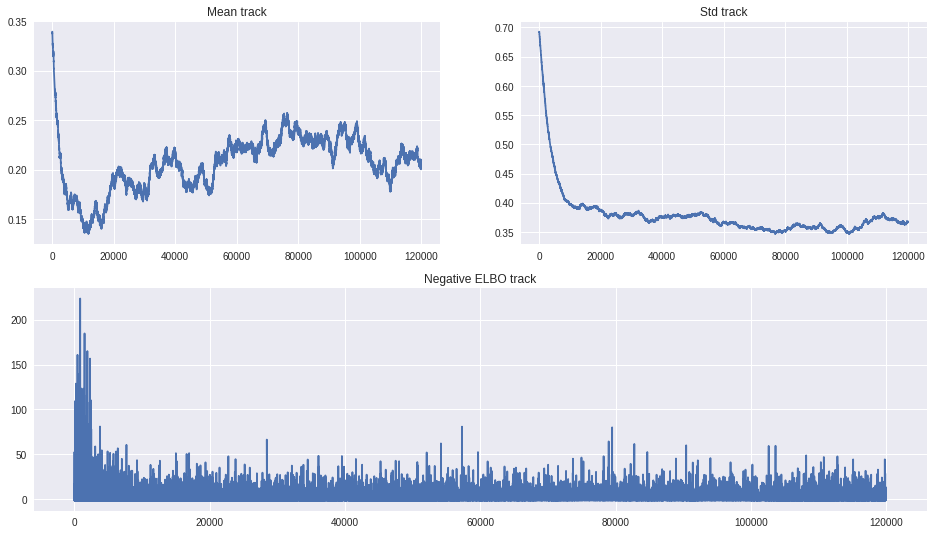

In [52]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

* 우리는 여전히 **수렴부족**을 볼 수 있다. **MEAN** 이 RANDOM WALK 안에서  양도되어 있다.
* 추론하는 데 있어서 나쁜 알고리즘을 선택한 결과이다. 
* 어쨋든 이것은 다른 RANDOM SEED를 사용할 때마다 다른 결과 값이 만들어지고 불안정 할 것이다.

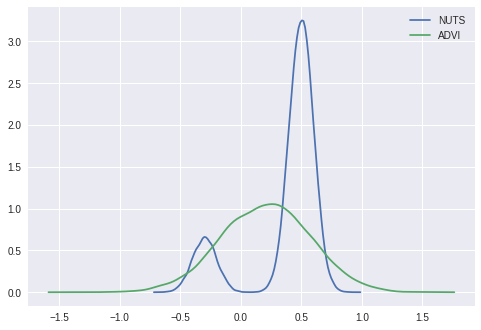

In [53]:
import seaborn as sns
import seaborn as sns
ax = sns.kdeplot(trace['x'], label='NUTS');
sns.kdeplot(approx.sample(10000)['x'], label='ADVI');

## Again, we see that ADVI is not able to cope with multimodality; 

* we can instead use **SVGD** , which generates an approximation based on a large number of particles.

In [54]:
with model :
    svgd_approx = pm.fit(300, method = "svgd" ,inf_kwargs = dict(n_particles=1000) , obj_optimizer = pm.sgd(learning_rate=0.01))

100%|██████████| 300/300 [00:48<00:00,  6.14it/s]


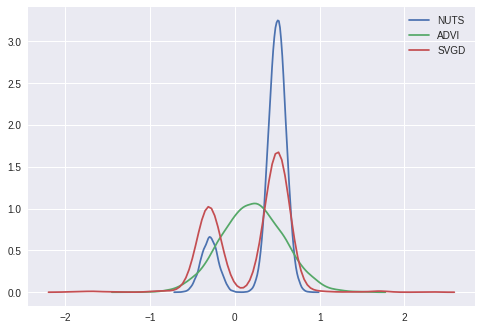

In [56]:
ax = sns.kdeplot(trace['x'], label='NUTS');
sns.kdeplot(approx.sample(10000)['x'], label='ADVI');
sns.kdeplot(svgd_approx.sample(2000)['x'], label='SVGD');

* Trick 이 성공하였다. **SVGD** 을 이용한 multimodal approximation 이 가능하다
* 모수에 대한 임의의 계산도 가능하다.  $ x^2  , sin(x) $도 계산 가능하다. (NUTS)

In [0]:
a= x**2
b= pm.math.sin(x)

In [58]:
help(svgd_approx.sample_node)

Help on method sample_node in module pymc3.variational.opvi:

sample_node(node, size=None, deterministic=False, more_replacements=None) method of pymc3.variational.approximations.Empirical instance
    Samples given node or nodes over shared posterior
    
    Parameters
    ----------
    node : Theano Variables (or Theano expressions)
    size : None or scalar
        number of samples
    more_replacements : `dict`
        add custom replacements to graph, e.g. change input source
    deterministic : bool
        whether to use zeros as initial distribution
        if True - zero initial point will produce constant latent variables
    
    Returns
    -------
    sampled node(s) with replacements



In [59]:
a_sample = svgd_approx.sample_node(a)
a_sample.eval()

array(0.19383874)

In [60]:
a_sample.eval()

array(0.14382553)

In [61]:
a_sample.eval()

array(0.32420958)

*  같은 theano node 로 부터 다른 값들을 출력한다. 이것은 **Stochastic** 하기 때문이다.
* replacement를 적용함으로 써 우리는 pymc3에 의존성이 없어지고 대신에 우리는 approximation에 의존하게 된다.
* 그것을 변화하는 것은 확률적인 노드 분포를 변화하는 것이다.

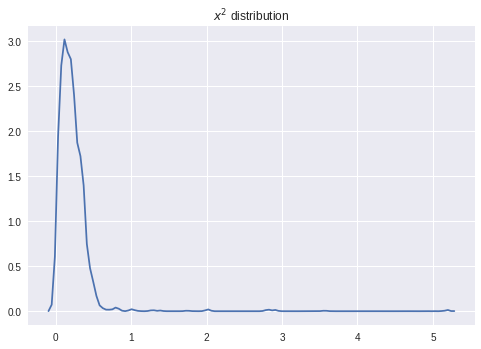

In [62]:

sns.kdeplot(np.array([a_sample.eval() for _ in range(2000)]));
plt.title('$x^2$ distribution');

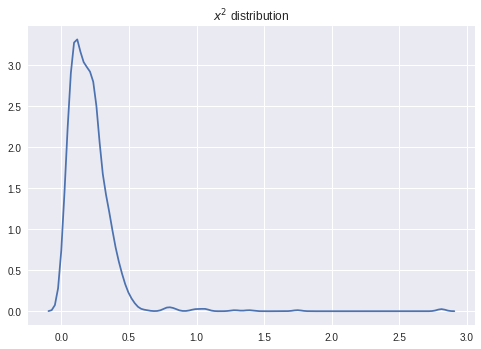

In [65]:
## 더 간편하게 식 가능 
a_samples = svgd_approx.sample_node(a, size=1000)
sns.kdeplot(a_samples.eval());
plt.title('$x^2$ distribution');

## sample_node 함수는 추갖거인 차원을 포함한다. axis=0 에 따라서 분산을 계산해주거나 기댓값을 계산 할 수 있다.

In [69]:
print("variance" , a_samples.var(axis=0).eval())
print("mean", a_samples.mean(axis=0).eval())

variance 0.05738621505195123
mean 0.22881645133811326


In [0]:
## A symbolic sample size can also be specified:

i = theano.tensor.iscalar('i')
i.tag.test_value = 1

a_samples_i = svgd_approx.sample_node(a, size=i)

In [72]:
print(a_samples_i.eval({i: 100}).shape)
print(a_samples_i.eval({i: 10000}).shape)

## 안타깝게도 사이즈는 무조건 scalar value 이다

(100,)
(10000,)


## Converting a Trace to an Approximation

* MCMCM trace 를 Approximation으로 전환할수 있다. 
* 같은 **sample_node**  근사화 하는 방법처럼  같은 api 가지고 있다.

In [73]:
trace_approx = pm.Empirical(trace, model = model)
trace_approx

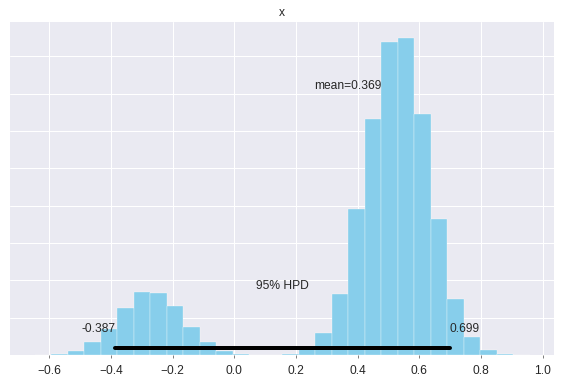

In [75]:
pm.plot_posterior(trace_approx.sample(100000))

![iris](https://thumb.ibb.co/hwdYfd/iris.png)

**Tracker** 를 설명하기 위해 iris dataset을 이용하겠다.

**multi label classification** 을 해보고 정확도롤 예측해본다.

In [0]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import theano.tensor as tt
import pandas as pd

X, y = load_iris(True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

* 심플 모델로도 충분하기 때문에 우리는 여기서 선형으로 분리를 해볼 것이다.  multinomial logistic regression을 해볼 것이다.

In [0]:
Xt = theano.shared(X_train)
yt = theano.shared(y_train)

with pm.Model() as iris_model :
    ## coeff for features
    b = pm.Normal("b" , 0 , sd=1e2 ,shape=(4,3))
    # transform to unit interval 
    a = pm.Flat("a", shape=(3,))
    p = tt.nnet.softmax(Xt.dot(b) + a)
    observed = pm.Categorical("obs", p=p , observed=yt)

## Pymc3 모델들은 잠재변를 위한 인풋 심볼을 가지고 있다.

* 잠재변수의 지식의 표현을 평가하기 위해 고정된 값을 제공 해야 한다.
* 우리는 이러한 목적으로 **VI** 를 근사화한 값으로 사용 할 수 있다. 
* sample_node 함수는 상징적인 의존을 제거 할 수 있다
*  **sample_node** 는 각각의 스텝마다 전체 분소를 사용할 것이다.
*  단일 함수안에 대체물을 적용하는 **more_replacements** keyword를 호출할 것이다 두 replacenet functions 에다가



```
    HINT: You can use more_replacements argument when calling fit too: * 

    pm.fit(more_replacements={full_data: minibatch_data}) 
    
    inference.fit(more_replacements={full_data: minibatch_data})
```

size =100 인 샘플 확률을 시힝했다 각각의 관측치 (sample_node는 아직 없는 것이 default)

In [0]:
with iris_model :
    
    # svgd
    inference = pm.SVGD(n_particles= 500, jitter =1 )
    
    # 근사화에 지역적인 참고
    approx = inference.approx
    
    # more_replacements  to change train_set to test_set
    test_probs = approx.sample_node(p , more_replacements={Xt : X_test } ,size= 100)
    
    # For train set no more replacements needed
    train_probs = approx.sample_node(p)

In [0]:
test_ok = tt.eq(test_probs.argmax(-1), y_test)
train_ok = tt.eq(train_probs.argmax(-1), y_train)
test_accuracy = test_ok.mean(-1)
train_accuracy = train_ok.mean(-1)

In [0]:
eval_tracker = pm.callbacks.Tracker(
    test_accuracy=test_accuracy.eval,
    train_accuracy=train_accuracy.eval
)

In [82]:

inference.fit(100, callbacks=[eval_tracker]);

100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Text(0.5,1,'Training Progress')

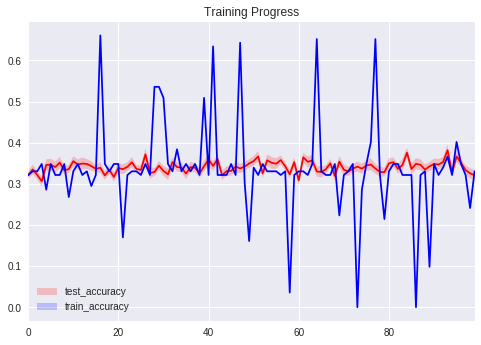

In [83]:
import seaborn as sns

sns.tsplot(np.asarray(eval_tracker['test_accuracy']).T, color='red')
sns.tsplot(np.asarray(eval_tracker['train_accuracy']).T, color='blue')
plt.legend(['test_accuracy', 'train_accuracy'])
plt.title('Training Progress')

In [84]:
inference.fit(400, obj_optimizer=pm.adamax(learning_rate=0.1), callbacks=[eval_tracker]);


100%|██████████| 400/400 [00:31<00:00, 12.55it/s]


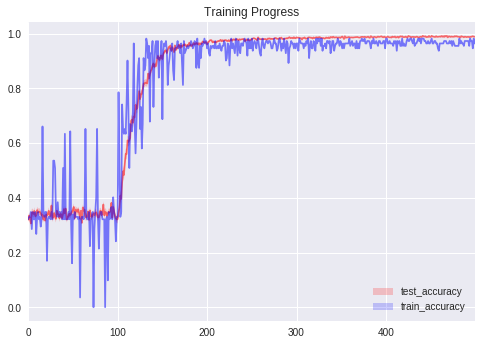

In [85]:
sns.tsplot(np.asarray(eval_tracker['test_accuracy']).T, color='red', alpha=.5)
sns.tsplot(np.asarray(eval_tracker['train_accuracy']).T, color='blue', alpha=.5)
plt.legend(['test_accuracy', 'train_accuracy'])
plt.title('Training Progress');

## Tracker allows us to monitor our approximation and choose good training schedule.

# Minibatches 

* 큰 데이터를 처리 할 때 미니배치 트렝을 사용하는 것은 속도 향상과 근사 성능을 향상시킨다. 
* 큰 데이터 셋은 많은 양의 gradients를 계산 해야 한다. 
*  답은 **pm.Minibatch** 이다.


In [86]:
issubclass(pm.Minibatch, theano.tensor.TensorVariable)

True

In [0]:
# Raw values
data = np.random.rand(40000, 100)
# Scaled values
data *= np.random.randint(1, 10, size=(100,))
# Shifted values
data += np.random.rand(100) * 1

In [0]:
with pm.Model() as model :
    mu = pm.Flat("mu", shape=(100, ))
    sd = pm.HalfNormal("sd" , shape=(100 , ))
    lik = pm.Normal("lik", mu, sd ,observed= data)
    
# 느린 최적화 기법을 멈추게 하는 callback 방법을 만들어 보자

In [0]:
def stop_after_10(approx , loss_history , i ) :
    if (i>0) and (i%10) ==0 :
        raise StopIteration("I was slow, sorry")

In [90]:
with model :
    advifit = pm.fit(callbacks=[stop_after_10])

Average Loss = 1.0134e+08:   0%|          | 9/10000 [00:01<21:50,  7.62it/s]
I was slow, sorry
Interrupted at 9 [0%]: Average Loss = 1.2002e+08


## 추론은 너무 느리다 . 반복하는 동안 몇초가 걸린다. 
* 근사화의 맞추게 하는 것은 시간이 걸린다.
*  여기서 **minibatch**를 사용하자 

total_size 는 관측된 것 안에서 해야한다.


In [0]:
X =pm.Minibatch(data , batch_size= 500)

with pm.Model() as model :
    
    mu = pm.Flat("mu" , shape=(100,))
    sd= pm.HalfNormal("sd", shape=(100,) )
    likelihood = pm.Normal("likelihood", mu,sd , observed = X ,total_size= data.shape)
                 

In [92]:
with model :
    advifit = pm.fit()

Average Loss = 7.5495e+06: 100%|██████████| 10000/10000 [00:24<00:00, 402.53it/s]


Finished [100%]: Average Loss = 7.547e+06


* 미니배치 추론은 엄청 빠르다 다차원 미니배치는  모델이 너무 넓거나 또는 매트릭스 분해하는 식으로 해야한다.

In [93]:
print(pm.Minibatch.__doc__)

Multidimensional minibatch that is pure TensorVariable

    Parameters
    ----------
    data : :class:`ndarray`
        initial data
    batch_size : `int` or `List[int|tuple(size, random_seed)]`
        batch size for inference, random seed is needed 
        for child random generators
    dtype : `str`
        cast data to specific type
    broadcastable : tuple[bool]
        change broadcastable pattern that defaults to `(False, ) * ndim`
    name : `str`
        name for tensor, defaults to "Minibatch"
    random_seed : `int`
        random seed that is used by default
    update_shared_f : `callable`
        returns :class:`ndarray` that will be carefully 
        stored to underlying shared variable
        you can use it to change source of 
        minibatches programmatically 
    in_memory_size : `int` or `List[int|slice|Ellipsis]`
        data size for storing in theano.shared

    Attributes
    ----------
    shared : shared tensor
        Used for storing data
    mini